In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve
from manual_review_classifier.Analysis import  print_accuracy_and_classification_report

# sns.set_style("white")
sns.set_context('paper')

Using TensorFlow backend.


In [4]:
training_data = pd.read_pickle('../data/training_data3.pkl')
training_data.sort_index(axis=1, inplace=True)
# Remove validation sample
training_data = training_data[~training_data.index.str.contains('H_KA-452198')]

In [5]:
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [6]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [7]:
three_class = training_data.replace('g', 'f')
three_class.call.value_counts()

s    18381
f    11976
a    10643
Name: call, dtype: int64

In [8]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [11]:
X_train.shape

(27470, 71)

In [12]:
Y_train.shape

(27470, 3)

In [13]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [14]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
if not os.path.exists('../data/log_reg/threeclass_relu_probs.npy'):
    probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')
    np.save('../data/log_reg/threeclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/log_reg/threeclass_relu_probs.npy')

In [16]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [17]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [18]:
print_accuracy_and_classification_report(Y_train, predicted_transformed)

Cross validation accuracy:
	 0.826756461594

Cross validation classification report

             precision    recall  f1-score   support

          0       0.75      0.67      0.70      7189
          1       0.89      0.86      0.88      8015
          2       0.83      0.90      0.86     12266

avg / total       0.83      0.83      0.82     27470



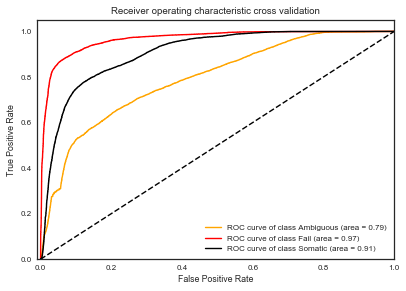

In [19]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(Y_train, probabilities, class_lookup, 'Receiver operating'
                 ' characteristic cross validation')

confidence intervals +-:  [ 0.00159393  0.00533031  0.00497537  0.01044351  0.01550653  0.02165061
  0.02870916  0.04769853  0.05305761  0.00486715]


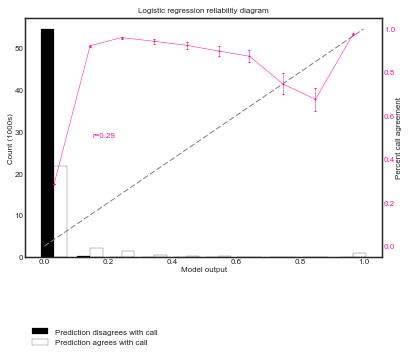

In [21]:
fig, ax = plt.subplots()
create_reliability_diagram(probabilities, Y_train,['Ambiguous','Fail','Somatic'], 'deeppink', 'Logistic regression reliability diagram',
                           ax, True, True, True)

### 1/3 Hold out set analysis

In [22]:
estimator.fit(X_train, Y_train)
test_probs = estimator.predict_proba(X_test)
X_test.shape

(13530, 71)

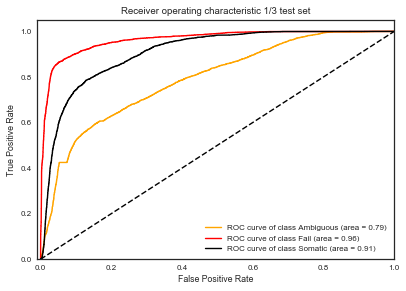

In [23]:
create_roc_curve(Y_test, test_probs, class_lookup, 'Receiver operating'
                 ' characteristic 1/3 test set')

confidence intervals +-:  [ 0.00226676  0.00699791  0.00799573  0.01464425  0.02275802  0.02967147
  0.03155302  0.04136575  0.054314    0.00893869]


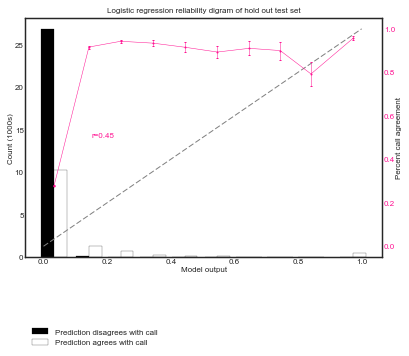

In [24]:
fig, ax = plt.subplots()
create_reliability_diagram(test_probs, Y_test,['Ambiguous','Fail','Somatic'], 'deeppink', 'Logistic regression reliability digram of hold out test set',
                          ax, True, True, True)